In [ ]:
!pip install transformers==4.17.0 -q

# Contextualized Word Embedding from BERT

In this notebook, we will use BERT to extract features, namely word and sentence embedding vectors, from text data. 

In the past, words have been represented either as uniquely indexed values (one-hot encoding), or more helpfully as neural word embeddings where vocabulary words are matched against the fixed-length feature embeddings that result from models like Word2Vec or Fasttext. BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. 

For example, given two sentences:

"An apple is sweet in taste."

"Both Apple and Huawei have wireless charging features."

Word2Vec would produce the same word embedding for the word "apple" in both sentences, while under BERT the word embedding for "apple" would be different for each sentence. Aside from capturing obvious differences like polysemy, the context-informed word embeddings capture other forms of information that result in more accurate feature representations, which in turn results in better model performance.


In [2]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np

### Load the pre-trained model

In [3]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model tokenizer (vocabulary)
model = BertModel.from_pretrained('bert-base-uncased')

Downloading: 100%|████████████████████████████| 226k/226k [00:01<00:00, 140kB/s]
Downloading: 100%|███████████████████████████| 28.0/28.0 [00:00<00:00, 9.60kB/s]
Downloading: 100%|██████████████████████████████| 570/570 [00:00<00:00, 142kB/s]
Downloading: 100%|███████████████████████████| 420M/420M [00:26<00:00, 16.6MB/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel

### Prepare Toy Corpus

six sentences containing the token: "apple" from two different senses.

In [4]:
sentence_samples = ["An apple is sweet in taste.",  "We can make juice and jam from apple.", "An apple a day keeps the doctor away.", "Investors in Apple have a love-hate relationship with the iPhone.", "Both Apple and Huawei have wireless charging features.", "Steve Jobs returned to Apple in 1196."]
df_samples = pd.DataFrame(sentence_samples, columns =['TEXT'])

In [5]:
df_samples

,TEXT
0,An apple is sweet in taste.
1,We can make juice and jam from apple.
2,An apple a day keeps the doctor away.
3,Investors in Apple have a love-hate relationship with the iPhone.
4,Both Apple and Huawei have wireless charging features.
5,Steve Jobs returned to Apple in 1196.


## Step 1: Tokenization

Tokenize the sentences: split the sentence into a list of word and subwords defined in BERT Vocab. The process is given as：

1. Tokenization: breaking down of the sentence into tokens
2. Adding the [CLS] token at the beginning of the sentence
3. Adding the [SEP] token at the end of the sentence
4. Converting each token into their corresponding IDs in the model

For some words, the BERT tokenization function will first breaks the word into two subwoards, namely characteristic and ##ally, where the first token is a more commonly-seen word (prefix) in a corpus, and the second token is prefixed by two hashes ## to indicate that it is a suffix following some other subwords.

In [6]:
tokenized = df_samples['TEXT'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

### Check one example

In [7]:
check_idx = 4
print("======input sentence======")
print(df_samples['TEXT'][check_idx])
breaken_words = []
for idx in tokenized[check_idx]:
    breaken_words.append(tokenizer.convert_ids_to_tokens(idx))
print("======after breaking======")
print(" ".join(breaken_words))
print("======Convert to IDs======")
print((tokenized[check_idx]))

======input sentence======
Both Apple and Huawei have wireless charging features.
======after breaking======
[CLS] both apple and hua ##wei have wireless charging features . [SEP]
======Convert to IDs======
[101, 2119, 6207, 1998, 23064, 19845, 2031, 9949, 13003, 2838, 1012, 102]



## Step 2: Padding
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [8]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(padded.shape)

(6, 15)


In [9]:
print(padded[0])
print(tokenizer.convert_ids_to_tokens(0))

[ 101 2019 6207 2003 4086 1999 5510 1012  102    0    0    0    0    0
    0]
[PAD]


## Step 3: Masking
If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is

In [10]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(6, 15)

## Step 4: Use the pre-trained BERT Model
fed the input sequence and the attention mask into the model

In [11]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    ## the output here is a tuple of (last_hidden_state, pooler_output)
    model_outputs = model(input_ids, attention_mask=attention_mask)

you can find more information about outputs here: 
https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel

In [12]:
# get the last_hidden state
last_hidden_state = model_outputs[0].numpy()

In [13]:
last_hidden_state.shape

(6, 15, 768)

##### Visualization of the output tensor

![picture](https://github.com/rz0718/colab_imgs/blob/main/imgs/bert_output_word.png?raw=true)

### Extract Word Embeddings

In our example setencens, we extract word vectors for the word: **apple**. To confirm that the value of these vectors are in fact contextually dependent, we check the pair-wise similarities. 

In [14]:
apple_idx =  tokenizer.convert_tokens_to_ids("apple")
vectors_apple = []
for idx in range(len(sentence_samples)):
    #idx is the sentence index
    #tokenized[idx].index(apple_idx) return the position of "apple" in the idx-th sentence
    apple_vec = last_hidden_state[idx, tokenized[idx].index(apple_idx),:]
    vectors_apple.append(apple_vec)

In [15]:
vectors_apple = np.array(vectors_apple)
vectors_apple.shape

(6, 768)

#### Pair-wise Similarity Computation

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
similarities = cosine_similarity(vectors_apple)
print('pairwise similarities output:\n {}\n'.format(similarities))

pairwise similarities output:
 [[1.0000002  0.7352113  0.815302   0.52664346 0.47562084 0.4960746 ]
 [0.7352113  0.9999992  0.70753527 0.50937325 0.47925133 0.46892264]
 [0.815302   0.70753527 1.         0.46320385 0.41884467 0.44034526]
 [0.52664346 0.50937325 0.46320385 1.0000001  0.8243001  0.76693135]
 [0.47562084 0.47925133 0.41884467 0.8243001  1.0000002  0.7225329 ]
 [0.4960746  0.46892264 0.44034526 0.76693135 0.7225329  0.9999999 ]]



In [18]:
df_similarity = pd.DataFrame(similarities,
                             index=sentence_samples,
                             columns=sentence_samples)

In [19]:
df_similarity

,An apple is sweet in taste.,We can make juice and jam from apple.,An apple a day keeps the doctor away.,Investors in Apple have a love-hate relationship with the iPhone.,Both Apple and Huawei have wireless charging features.,Steve Jobs returned to Apple in 1196.
An apple is sweet in taste.,1.000000,0.735211,0.815302,0.526643,0.475621,0.496075
We can make juice and jam from apple.,0.735211,0.999999,0.707535,0.509373,0.479251,0.468923
An apple a day keeps the doctor away.,0.815302,0.707535,1.000000,0.463204,0.418845,0.440345
Investors in Apple have a love-hate relationship with the iPhone.,0.526643,0.509373,0.463204,1.000000,0.824300,0.766931
Both Apple and Huawei have wireless charging features.,0.475621,0.479251,0.418845,0.824300,1.000000,0.722533
Steve Jobs returned to Apple in 1196.,0.496075,0.468923,0.440345,0.766931,0.722533,1.000000


#### Visualize the similarity matrix

In [20]:
import seaborn as sns

<AxesSubplot: >

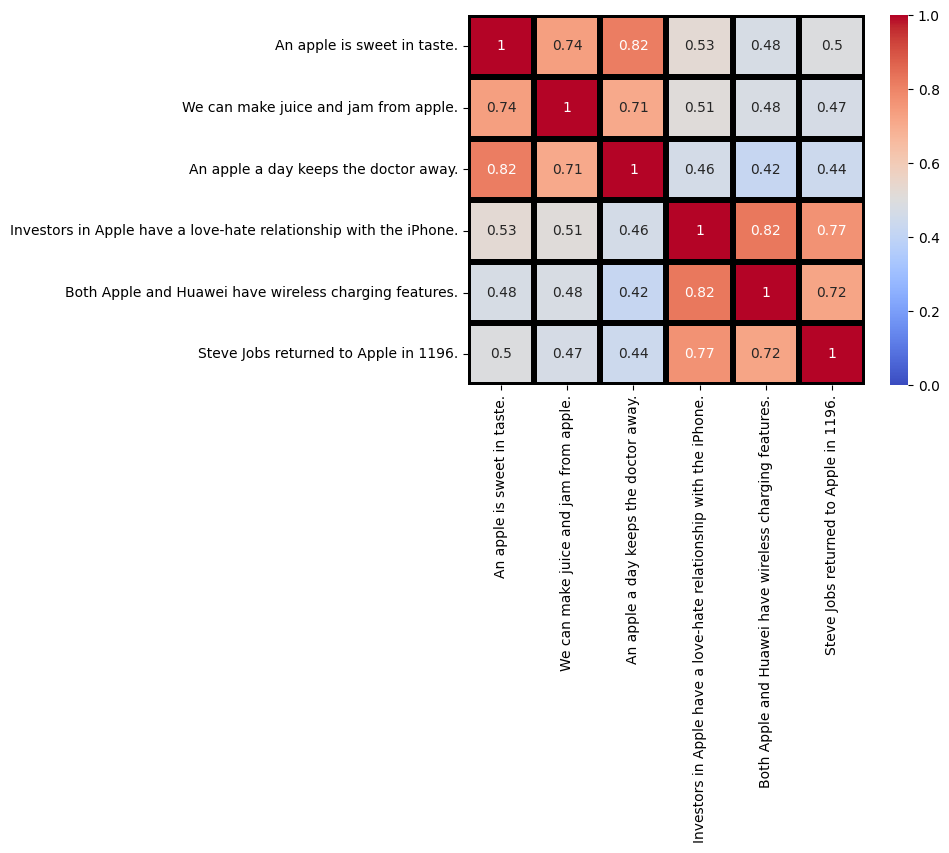

In [21]:
sns.heatmap(df_similarity, 
            annot = True, 
            vmin=0, vmax=1, 
            center= 0.5, 
            cmap= 'coolwarm', 
            linewidths=3, 
            linecolor='black')

**BERT Authors**

The BERT authors tested word-embedding strategies by feeding different vector combinations as input features to a BiLSTM used on a named entity recognition task and observing the resulting F1 scores.

(Image from [Jay Allamar](http://jalammar.github.io/illustrated-bert/)'s blog)


![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

While concatenation of the last four layers produced the best results on this specific task, many of the other methods come in a close second and in general it is advisable to test different versions for your specific application: results may vary.

This is partially demonstrated by noting that the different layers of BERT encode very different kinds of information, so the appropriate pooling strategy will change depending on the application because different layers encode different kinds of information. 
